# Clustering Analysis

In this analysis we are looking at spatial variation of clusters relating to health and deprivation-related variables. Health is represented by number of deaths by preventable causes, found on on [Public Health England](https://fingertips.phe.org.uk/search/mortality). All data used in this analysis can be found on the relevant [Github Repo](https://github.com/signesw/Seeya_later).

This iteration of the analysis has greater disaggregation of ethnicity categories from 2011 Census and has removed 'population over 65' to focus on 'population over 85'.

## Import Packages

In [1]:
#Importing packages

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

In [2]:
#Importing machine learning packages and formatting

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [3]:
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## Loading MSOA shapefile

<AxesSubplot:>

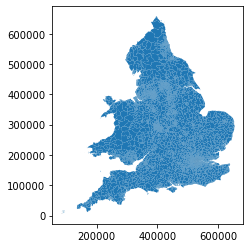

In [4]:
#loading the MSOAs for England and Wales

msoas = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true')
msoas.plot()

In [5]:
msoas.sample(3)

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
4512,4513,E02004616,Cotswold 002,Cotswold 002,419772,228556,-1.71,51.96,"106,158,692.62","76,239.60","POLYGON ((425815.906 237703.891, 425875.781 23..."
4660,4661,E02004768,Havant 007,Havant 007,468765,108410,-1.02,50.87,"1,489,727.28","6,299.57","POLYGON ((469134.341 109156.507, 469443.952 10..."
1038,1039,E02001074,Manchester 030,Manchester 030,383854,394300,-2.24,53.45,"1,933,712.23","7,950.69","POLYGON ((385403.077 394868.355, 385168.713 39..."


In [6]:
msoas.shape


(7201, 11)

In [7]:
msoas_england = msoas[msoas.MSOA11CD.str.startswith('E')]

In [8]:
msoas_england.head()

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
0,1,E02000001,City of London 001,City of London 001,532384,181355,-0.09,51.52,"2,906,360.96","8,936.82","POLYGON ((532135.138 182198.131, 532158.250 18..."
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189685,0.14,51.59,"2,166,163.21","8,150.41","POLYGON ((548881.563 190845.265, 548881.125 19..."
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188520,0.14,51.58,"2,143,567.81","9,118.20","POLYGON ((549102.438 189324.625, 548954.517 18..."
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186412,0.18,51.56,"2,491,466.74","8,206.55","POLYGON ((551550.056 187364.705, 551478.000 18..."
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186824,0.14,51.56,"1,186,053.13","6,949.69","POLYGON ((549099.634 187656.076, 549161.375 18..."


In [9]:
msoas_england.shape

(6791, 11)

In [10]:
to_drop = ['MSOA11NMW','LONG','LAT','Shape__Are','Shape__Len']
msoas_england.drop(columns=to_drop, inplace = True)
print(msoas_england.shape)

(6791, 6)


C:\Users\Yasmine Hujair\anaconda32020\envs\SpatialData\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
msoas_england.head()

,OBJECTID,MSOA11CD,MSOA11NM,BNG_E,BNG_N,geometry
0,1,E02000001,City of London 001,532384,181355,"POLYGON ((532135.138 182198.131, 532158.250 18..."
1,2,E02000002,Barking and Dagenham 001,548267,189685,"POLYGON ((548881.563 190845.265, 548881.125 19..."
2,3,E02000003,Barking and Dagenham 002,548259,188520,"POLYGON ((549102.438 189324.625, 548954.517 18..."
3,4,E02000004,Barking and Dagenham 003,551004,186412,"POLYGON ((551550.056 187364.705, 551478.000 18..."
4,5,E02000005,Barking and Dagenham 004,548733,186824,"POLYGON ((549099.634 187656.076, 549161.375 18..."


In [12]:
msoas_england['borough'] = msoas_england.MSOA11NM.str.replace(r' \d+','',regex=True)

C:\Users\Yasmine Hujair\anaconda32020\envs\SpatialData\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [13]:
#### Add MSOA Names using a Merge

#The House of Commons Library provides a [MSOA Names](https://visual.parliament.uk/msoanames) data set that contains locally-relevant names applied to MSOAs. 
#These seek to connect the Census geography (OA > LSOA > MSOA > LA) to a loosely-defined 'neighbourhood'.

In [14]:
msoa_nms = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/src/MSOA-Names-1.8.csv.gz?raw=true', compression='gzip')

In [15]:
print(msoa_nms.columns.values)
msoa_nms.sample(3, random_state=42)

['msoa11cd' 'msoa11nm' 'msoa11nmw' 'msoa11hclnm' 'msoa11hclnmw' 'Laname']


,msoa11cd,msoa11nm,msoa11nmw,msoa11hclnm,msoa11hclnmw,Laname
4512,E02005951,Oxford 012,Oxford 012,Grandpont & New Hinksey,NaN,Oxford
4660,W02000113,Powys 017,Powys 017,Brecon,Aberhonddu,Powys
1038,W02000309,Caerphilly 020,Caerffili 020,Bedwas & Trethomas,Bedwas a Thretomas,Caerphilly


In [16]:
msoas = pd.merge(msoas_england, msoa_nms, how = 'inner' , left_on = 'MSOA11CD', right_on = 'msoa11cd')
print(msoas.shape)
print(type(msoas)) # You should check this -- result isn't always be a GeoDataFrame
msoas.sample(3, random_state=42)[['OBJECTID','MSOA11CD','MSOA11NM','msoa11hclnm']]

(6791, 13)
<class 'geopandas.geodataframe.GeoDataFrame'>


,OBJECTID,MSOA11CD,MSOA11NM,msoa11hclnm
3142,3143,E02003230,Swindon 019,Central South & Eastcott
3076,3077,E02003161,Torbay 008,Torquay Central
101,102,E02000104,Brent 012,Wembley North


In [17]:
msoas.columns

Index(['OBJECTID', 'MSOA11CD', 'MSOA11NM', 'BNG_E', 'BNG_N', 'geometry',
       'borough', 'msoa11cd', 'msoa11nm', 'msoa11nmw', 'msoa11hclnm',
       'msoa11hclnmw', 'Laname'],
      dtype='object')

In [18]:
# tidy up
to_drop = ['msoa11cd','msoa11nm','msoa11nmw','Laname','msoa11hclnmw']
msoas.drop(columns=to_drop, inplace=True)
print(msoas.shape)

(6791, 8)


In [19]:
msoas.columns

Index(['OBJECTID', 'MSOA11CD', 'MSOA11NM', 'BNG_E', 'BNG_N', 'geometry',
       'borough', 'msoa11hclnm'],
      dtype='object')

In [20]:
# SAVE

msoas.to_file(os.path.join('data','England_MSOAs.gpkg'), driver='GPKG')

## Importing all data

### Health data


In [21]:
# Set download URL
url = 'https://raw.githubusercontent.com/signesw/Seeya_later/main/data/preventable_deaths_phe.csv'
deaths = pd.read_csv(url, low_memory=False)
print(f"Data frame is {deaths.shape[0]:,} x {deaths.shape[1]}")

Data frame is 6,791 x 5


In [22]:
deaths.head()

,Code,Label,Deaths from causes considered preventable\nlower confidence limit,Deaths from causes considered preventable,Deaths from causes considered preventable\nupper confidence limit
0,E02000001,City of London 001,49.90,68.50,91.60
1,E02000002,Barking and Dagenham 001,68.30,93.60,125.20
2,E02000003,Barking and Dagenham 002,79.80,101.80,128.00
3,E02000004,Barking and Dagenham 003,83.40,110.70,144.00
4,E02000005,Barking and Dagenham 004,79.10,103.90,134.00


In [23]:
deaths = deaths[['Code', 'Label', 'Deaths from causes considered preventable']]

In [24]:
deaths.head()

,Code,Label,Deaths from causes considered preventable
0,E02000001,City of London 001,68.50
1,E02000002,Barking and Dagenham 001,93.60
2,E02000003,Barking and Dagenham 002,101.80
3,E02000004,Barking and Dagenham 003,110.70
4,E02000005,Barking and Dagenham 004,103.90


In [25]:
deaths.shape

(6791, 3)

### Demographic data

In [26]:
## Reading in household poverty after housing costs
## IMD 2019 available at LSOA but was downloaded from https://research.mysociety.org/sites/imd2019/about/ at MSOA level
#the IMD decile was aggregated and averaged across the LSOAs that fall into the MSOAs

In [27]:
# Set download URL
url = 'https://raw.githubusercontent.com/signesw/Seeya_later/main/data/IMD2019-demographs-MSOA.csv'
socio_demo = pd.read_csv(url, low_memory=False)
socio_demo.head()

,MSOAC,MSOAHOCLN,LAD19C,LAD19N,REG,LSOACOUNT,POPMID15,IMD19 SCORE,MSOARANK,MSOADECILE,MSOAQUINTILE,Percentage of Households Below 60% of the Median Income; (after housing costs),Percentage of Households Below 60% of the Median Income; (after housing costs); 95% Confidence Interval Lower Limit,Percentage of Households Below 60% of the Median Income; (after housing costs); 95% Confidence Interval Upper Limit
0,E02000001,City of London,E09000001,City of London,London,6.00,"6,687.00",14.72,"4,198.00",7.00,4.00,15.50,8.10,27.40
1,E02000002,Marks Gate,E09000002,Barking and Dagenham,London,4.00,"7,379.00",34.77,"1,060.00",2.00,1.00,28.10,21.30,35.80
2,E02000003,Chadwell Heath East,E09000002,Barking and Dagenham,London,6.00,"10,720.00",25.15,"2,200.00",4.00,2.00,21.60,16.00,28.30
3,E02000004,Eastbrookend,E09000002,Barking and Dagenham,London,4.00,"6,536.00",23.56,"2,429.00",4.00,2.00,22.20,16.40,29.20
4,E02000005,Becontree Heath,E09000002,Barking and Dagenham,London,5.00,"9,243.00",30.21,"1,519.00",3.00,2.00,23.10,17.00,30.50


In [28]:
url = 'https://raw.githubusercontent.com/signesw/Seeya_later/main/data/community_data.csv'
pop_and_demo = pd.read_csv(url, low_memory=False)
pop_and_demo.rename(columns={'Code':'MSOAC'}, inplace=True)
pop_and_demo.head()

,MSOAC,Label,Black and Minority Ethnic Population\nlower confidence limit,Black and Minority Ethnic Population,Black and Minority Ethnic Population\nupper confidence limit,Long Term Unemployment\nlower confidence limit,Long Term Unemployment,Long Term Unemployment\nupper confidence limit,Index of Multiple Deprivation (IMD) Score 2015,Proportion of households in poverty\nlower confidence limit,...,Population aged 16 to 24 years\nupper confidence limit,Population aged 25 to 64 years\nlower confidence limit,Population aged 25 to 64 years,Population aged 25 to 64 years\nupper confidence limit,Population aged 65 years and over\nlower confidence limit,Population aged 65 years and over,Population aged 65 years and over\nupper confidence limit,Population aged 85 years and over\nlower confidence limit,Population aged 85 years and over,Population aged 85 years and over\nupper confidence limit
0,E02000001,City of London 001,20.40,21.40,22.30,1.80,3.00,4.90,13.60,8.10,...,9.70,55.50,56.60,57.70,18.50,19.40,20.30,2.30,2.60,3.00
1,E02000002,Barking and Dagenham 001,33.90,35.00,36.20,5.20,7.30,10.20,38.50,21.30,...,11.30,47.20,48.30,49.40,13.00,13.70,14.50,2.60,3.00,3.40
2,E02000003,Barking and Dagenham 002,44.40,45.40,46.40,2.50,3.70,5.40,25.70,16.00,...,10.80,53.10,54.10,55.00,11.60,12.20,12.90,1.60,1.90,2.20
3,E02000004,Barking and Dagenham 003,18.10,19.00,20.00,5.70,7.90,11.10,24.80,16.40,...,14.20,49.20,50.40,51.60,15.40,16.30,17.20,3.00,3.40,3.80
4,E02000005,Barking and Dagenham 004,32.70,33.70,34.70,3.00,4.40,6.30,32.50,17.00,...,11.80,51.20,52.20,53.20,9.00,9.60,10.20,1.20,1.40,1.60


In [29]:
url = 'https://raw.githubusercontent.com/signesw/Seeya_later/main/data/Ethnicities.csv'
ethnicities = pd.read_csv(url,low_memory=False)
ethnicities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6791 entries, 0 to 6790
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   MSOA Code                         6791 non-null   object
 1   MSOA Name                         6791 non-null   object
 2   All                               6791 non-null   int64 
 3   White                             6791 non-null   int64 
 4   Asian/Asian British: Indian       6791 non-null   int64 
 5   Asian/Asian British: Pakistani    6791 non-null   int64 
 6   Asian/Asian British: Bangladeshi  6791 non-null   int64 
 7   Asian/Asian British: Chinese      6791 non-null   int64 
 8   Black                             6791 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 477.6+ KB


In [30]:
#reading in more detailed ethnicities data

url = 'https://raw.githubusercontent.com/signesw/Seeya_later/main/data/Ethnicities.csv'
ethnicities = pd.read_csv(url,low_memory=False)
#calculating percentages of total population per MSOA of each ethnicity
ethnicities[['White', 'Asian/Asian British: Indian',
             'Asian/Asian British: Pakistani', 'Asian/Asian British: Bangladeshi',
             'Asian/Asian British: Chinese', 'Black']] = ethnicities[['White', 'Asian/Asian British: Indian',
             'Asian/Asian British: Pakistani', 'Asian/Asian British: Bangladeshi',
             'Asian/Asian British: Chinese', 'Black']].divide(ethnicities['All'], axis='index')
#create 'other' column
ethnicities['Other'] = ethnicities[['White', 'Asian/Asian British: Indian',
             'Asian/Asian British: Pakistani', 'Asian/Asian British: Bangladeshi',
             'Asian/Asian British: Chinese', 'Black']].sum(axis=1)

ethnicities['Other'] = 1 - ethnicities['Other']

#creating combined categories of ethnicities 
ethnicities['Chinese_Other'] = ethnicities[['Asian/Asian British: Chinese','Other']].sum(axis=1)
ethnicities['Subcont'] = ethnicities[['Asian/Asian British: Indian', 'Asian/Asian British: Pakistani', 'Asian/Asian British: Bangladeshi']].sum(axis=1)

ethnicities.drop(['Asian/Asian British: Indian',
             'Asian/Asian British: Pakistani', 'Asian/Asian British: Bangladeshi',
             'Asian/Asian British: Chinese', 'Other'], axis=1, inplace = True)

ethnicities.head()

,MSOA Code,MSOA Name,All,White,Black,Chinese_Other,Subcont
0,E02002559,Darlington 001,8842,0.97,0.00,0.02,0.01
1,E02002560,Darlington 002,5997,0.98,0.00,0.01,0.01
2,E02002561,Darlington 003,5741,0.98,0.00,0.02,0.01
3,E02002562,Darlington 004,6066,0.96,0.00,0.02,0.01
4,E02002563,Darlington 005,5463,0.98,0.00,0.02,0.00


In [31]:
#merge dataframes
pop_and_demo = pd.merge(socio_demo, pop_and_demo, on = 'MSOAC')
pop_and_demo = pd.merge(ethnicities, pop_and_demo, left_on = 'MSOA Code', right_on = 'MSOAC')
pop_and_demo.head()

,MSOA Code,MSOA Name,All,White,Black,Chinese_Other,Subcont,MSOAC,MSOAHOCLN,LAD19C,...,Population aged 16 to 24 years\nupper confidence limit,Population aged 25 to 64 years\nlower confidence limit,Population aged 25 to 64 years,Population aged 25 to 64 years\nupper confidence limit,Population aged 65 years and over\nlower confidence limit,Population aged 65 years and over,Population aged 65 years and over\nupper confidence limit,Population aged 85 years and over\nlower confidence limit,Population aged 85 years and over,Population aged 85 years and over\nupper confidence limit
0,E02002559,Darlington 001,8842,0.97,0.00,0.02,0.01,E02002559,"Faverdale, Heighington & Sadberge",E06000005,...,8.20,52.20,53.20,54.30,18.60,19.40,20.30,1.40,1.60,1.90
1,E02002560,Darlington 002,5997,0.98,0.00,0.01,0.01,E02002560,Harrowgate Hill,E06000005,...,9.60,51.20,52.40,53.60,17.30,18.30,19.30,1.20,1.40,1.80
2,E02002561,Darlington 003,5741,0.98,0.00,0.02,0.01,E02002561,Whinfield,E06000005,...,8.70,51.20,52.60,53.90,22.50,23.60,24.70,2.10,2.50,3.00
3,E02002562,Darlington 004,6066,0.96,0.00,0.02,0.01,E02002562,Rise Carr,E06000005,...,11.40,52.40,53.70,54.90,17.00,18.00,19.00,2.30,2.70,3.10
4,E02002563,Darlington 005,5463,0.98,0.00,0.02,0.00,E02002563,Haughton Le Skerne,E06000005,...,10.00,47.60,48.90,50.30,24.30,25.40,26.60,4.40,5.00,5.60


In [32]:
pop_and_demo.columns

Index(['MSOA Code', 'MSOA Name', 'All', 'White', 'Black', 'Chinese_Other',
       'Subcont', 'MSOAC', 'MSOAHOCLN', 'LAD19C', 'LAD19N', 'REG', 'LSOACOUNT',
       'POPMID15', 'IMD19 SCORE', 'MSOARANK', 'MSOADECILE', 'MSOAQUINTILE',
       'Percentage of Households Below 60% of the Median Income; (after housing costs)',
       'Percentage of Households Below 60% of the Median Income; (after housing costs); 95% Confidence Interval Lower Limit',
       'Percentage of Households Below 60% of the Median Income; (after housing costs); 95% Confidence Interval Upper Limit',
       'Label', 'Black and Minority Ethnic Population\nlower confidence limit',
       'Black and Minority Ethnic Population',
       'Black and Minority Ethnic Population\nupper confidence limit',
       'Long Term Unemployment\nlower confidence limit',
       'Long Term Unemployment',
       'Long Term Unemployment\nupper confidence limit',
       'Index of Multiple Deprivation (IMD) Score 2015',
       'Proportion of hous

In [33]:
to_keep = ['MSOAC', 'Label', 'White', 'Black', 'Chinese_Other',
           'Subcont','Long Term Unemployment','IMD19 SCORE', 
           'Percentage of Households Below 60% of the Median Income; (after housing costs)',
           'Proportion of households in poverty',
           'Population 0 to 15 years','Population aged 16 to 24 years', 
           'Population aged 25 to 64 years', 'Population aged 65 years and over', 
           'Population aged 85 years and over']

pop_and_demo = pop_and_demo[to_keep]
pop_and_demo.head()

,MSOAC,Label,White,Black,Chinese_Other,Subcont,Long Term Unemployment,IMD19 SCORE,Percentage of Households Below 60% of the Median Income; (after housing costs),Proportion of households in poverty,Population 0 to 15 years,Population aged 16 to 24 years,Population aged 25 to 64 years,Population aged 65 years and over,Population aged 85 years and over
0,E02002559,Darlington 001,0.97,0.00,0.02,0.01,0.90,13.22,13.00,13.00,19.70,7.60,53.20,19.40,1.60
1,E02002560,Darlington 002,0.98,0.00,0.01,0.01,4.20,15.88,13.00,13.00,20.50,8.90,52.40,18.30,1.40
2,E02002561,Darlington 003,0.98,0.00,0.02,0.01,4.20,17.18,16.00,16.00,15.90,8.00,52.60,23.60,2.50
3,E02002562,Darlington 004,0.96,0.00,0.02,0.01,15.40,41.12,32.70,32.70,17.70,10.60,53.70,18.00,2.70
4,E02002563,Darlington 005,0.98,0.00,0.02,0.00,6.10,28.71,20.30,20.30,16.50,9.20,48.90,25.40,5.00


In [34]:
#Rename MSOAC to Code and merge deaths data to demographic data

pop_and_demo.rename(columns={'MSOAC':'Code','Label_x':'Label'}, inplace=True)
variables = pd.merge(deaths, pop_and_demo, on = 'Code')
variables.drop(['Label_y','Percentage of Households Below 60% of the Median Income; (after housing costs)'], axis = 1, inplace = True)
variables.rename(columns={'Label_x':'Label'}, inplace = True)
variables.columns

Index(['Code', 'Label', 'Deaths from causes considered preventable', 'White',
       'Black', 'Chinese_Other', 'Subcont', 'Long Term Unemployment',
       'IMD19 SCORE', 'Proportion of households in poverty',
       'Population 0 to 15 years', 'Population aged 16 to 24 years',
       'Population aged 25 to 64 years', 'Population aged 65 years and over',
       'Population aged 85 years and over'],
      dtype='object')

## Initial Clustering and Mapping

In [35]:
#creating gdf

gdf = pd.merge(msoas, variables, left_on = 'MSOA11CD', right_on = 'Code', how = 'inner')

gdf = gdf.drop(columns=['MSOA11CD','White']).rename(columns={'Code': 'MSOA_code', 
                                                                'Deaths from causes considered preventable' : 'preventable_deaths',
                                                                'IMD19 Score':'IMD19',
                                                                'Long Term Unemployment' : 'longterm_unemployed', 
                                                                'Proportion of households in poverty' : 'household_poverty',
                                                                'Population 0 to 15 years' : 'pop_0_15', 
                                                                'Population aged 16 to 24 years' : 'pop_16_24', 
                                                                'Population aged 25 to 64 years' : 'pop_25_64', 
                                                                'Population aged 65 years and over' : 'pop_above_65', 
                                                                'Population aged 85 years and over' : 'pop_above_85' })

print(f"England MSOA preventable deaths and demographics data frame has shape {gdf.shape[0]:,} x {gdf.shape[1]}")
gdf.head()

England MSOA preventable deaths and demographics data frame has shape 6,791 x 21


,OBJECTID,MSOA11NM,BNG_E,BNG_N,geometry,borough,msoa11hclnm,MSOA_code,Label,preventable_deaths,...,Chinese_Other,Subcont,longterm_unemployed,IMD19 SCORE,household_poverty,pop_0_15,pop_16_24,pop_25_64,pop_above_65,pop_above_85
0,1,City of London 001,532384,181355,"POLYGON ((532135.138 182198.131, 532158.250 18...",City of London,City of London,E02000001,City of London 001,68.50,...,0.12,0.06,3.00,14.72,15.50,15.10,9.00,56.60,19.40,2.60
1,2,Barking and Dagenham 001,548267,189685,"POLYGON ((548881.563 190845.265, 548881.125 19...",Barking and Dagenham,Marks Gate,E02000002,Barking and Dagenham 001,93.60,...,0.10,0.09,7.30,34.77,28.10,27.40,10.60,48.30,13.70,3.00
2,3,Barking and Dagenham 002,548259,188520,"POLYGON ((549102.438 189324.625, 548954.517 18...",Barking and Dagenham,Chadwell Heath East,E02000003,Barking and Dagenham 002,101.80,...,0.11,0.19,3.70,25.15,21.60,23.50,10.20,54.10,12.20,1.90
3,4,Barking and Dagenham 003,551004,186412,"POLYGON ((551550.056 187364.705, 551478.000 18...",Barking and Dagenham,Eastbrookend,E02000004,Barking and Dagenham 003,110.70,...,0.06,0.02,7.90,23.56,22.20,20.00,13.30,50.40,16.30,3.40
4,5,Barking and Dagenham 004,548733,186824,"POLYGON ((549099.634 187656.076, 549161.375 18...",Barking and Dagenham,Becontree Heath,E02000005,Barking and Dagenham 004,103.90,...,0.07,0.09,4.40,30.21,23.10,27.00,11.20,52.20,9.60,1.40


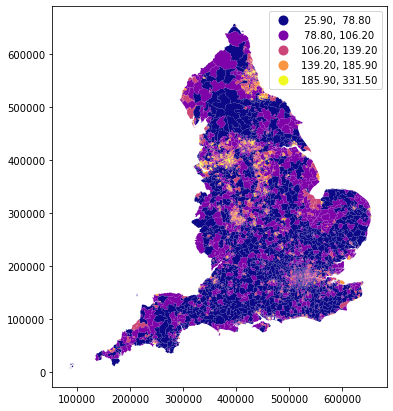

In [36]:
#Quick initial map
import mapclassify.classifiers as classifiers

gdf.plot(column='preventable_deaths', cmap='plasma', 
         scheme='FisherJenks', edgecolor='None', legend=True, figsize=(9,7));

In [37]:
gdf.columns

Index(['OBJECTID', 'MSOA11NM', 'BNG_E', 'BNG_N', 'geometry', 'borough',
       'msoa11hclnm', 'MSOA_code', 'Label', 'preventable_deaths', 'Black',
       'Chinese_Other', 'Subcont', 'longterm_unemployed', 'IMD19 SCORE',
       'household_poverty', 'pop_0_15', 'pop_16_24', 'pop_25_64',
       'pop_above_65', 'pop_above_85'],
      dtype='object')

In [38]:
gdf_vars = gdf[['preventable_deaths',
       'Black', 'Chinese_Other', 'Subcont', 'longterm_unemployed',
       'IMD19 SCORE', 'household_poverty', 'pop_0_15', 'pop_16_24',
       'pop_25_64', 'pop_above_85']] 

Text(0.5, 1.0, 'Correlation Matrix')

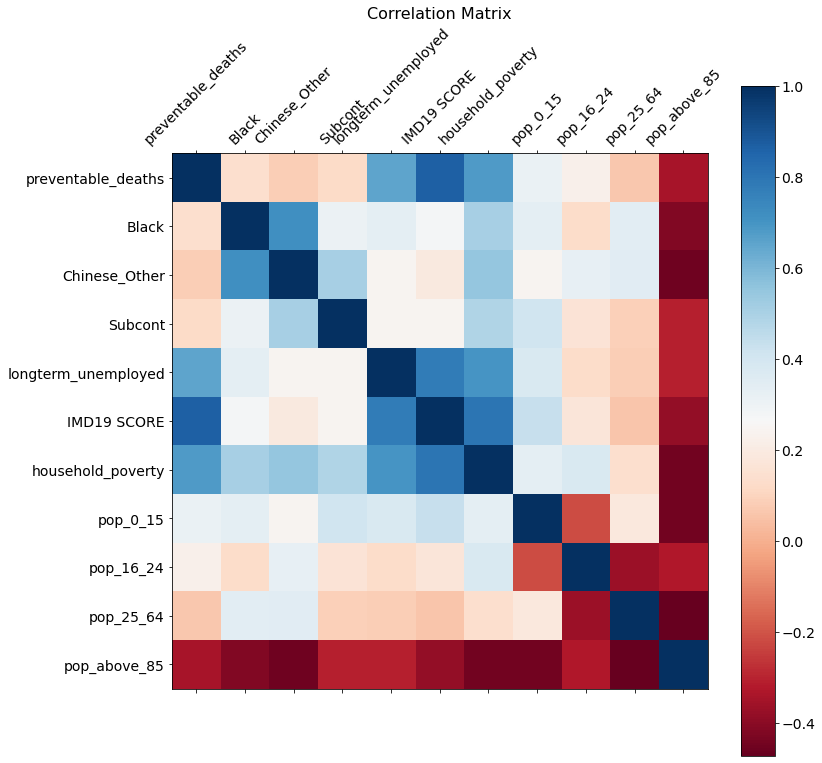

In [39]:
#plotting correlation matrix and checking for multicollinearity
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(12, 12))
plt.matshow(gdf_vars.corr(), fignum=f.number, cmap= 'RdBu')
#cmap = cm.jet
#cmaps['Perceptually Uniform Sequential'] = [ 'viridis', 'plasma', 'inferno', 'magma', 'cividis']

plt.xticks(range(gdf_vars.shape[1]), gdf_vars.columns, fontsize=14, rotation=45)
plt.yticks(range(gdf_vars.shape[1]), gdf_vars.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
#plt.savefig('correlation_matrix.png', bbox_inches='tight')
#plt.matshow(corr, cmap=cm.jet)

<AxesSubplot:>

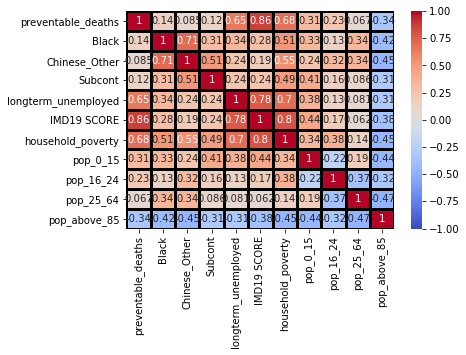

In [40]:
# trying this again with seaborn
# will make look nicer later
# code from this link:
#https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07


sns.heatmap(gdf_vars.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')


In [41]:
#### most likely to drop pop_above_85 as we already have pop_above_65
### also probably should drop IMD 2015 as we have IMD 2019

In [42]:
gdf_vars['MSOA11CD'] = gdf[['MSOA_code']]
gdf_vars = gdf_vars.fillna(0).set_index('MSOA11CD')
gdf_vars.head()

C:\Users\Yasmine Hujair\anaconda32020\envs\SpatialData\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,preventable_deaths,Black,Chinese_Other,Subcont,longterm_unemployed,IMD19 SCORE,household_poverty,pop_0_15,pop_16_24,pop_25_64,pop_above_85
MSOA11CD,,,,,,,,,,,
E02000001,68.50,0.03,0.12,0.06,3.00,14.72,15.50,15.10,9.00,56.60,2.60
E02000002,93.60,0.17,0.10,0.09,7.30,34.77,28.10,27.40,10.60,48.30,3.00
E02000003,101.80,0.16,0.11,0.19,3.70,25.15,21.60,23.50,10.20,54.10,1.90
E02000004,110.70,0.10,0.06,0.02,7.90,23.56,22.20,20.00,13.30,50.40,3.40
E02000005,103.90,0.17,0.07,0.09,4.40,30.21,23.10,27.00,11.20,52.20,1.40


In [43]:
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer()

In [44]:
for c in gdf_vars.columns.values:
    gdf_vars[c] = pts.fit_transform(gdf_vars[c].values.reshape(-1,1))
gdf_vars.head(3)

,preventable_deaths,Black,Chinese_Other,Subcont,longterm_unemployed,IMD19 SCORE,household_poverty,pop_0_15,pop_16_24,pop_25_64,pop_above_85
MSOA11CD,,,,,,,,,,,
E02000001,-1.01,0.55,1.52,1.05,0.31,-0.35,-0.60,-1.00,-0.21,1.00,0.23
E02000002,-0.06,2.04,1.24,1.42,1.23,1.07,0.99,2.10,0.51,-0.76,0.55
E02000003,0.18,2.03,1.38,1.98,0.53,0.52,0.33,1.14,0.36,0.46,-0.41


In [ ]:
sns.set(style="white")
sns.pairplot(gdf_vars, markers=".", height=3, diag_kind='kde');

In [46]:
# We also create a 'result set' (rs) data frame to hold the 
# results of the clustering operation
rs   = pd.merge(msoas, gdf_vars, left_on='MSOA11CD', right_index=True).set_index('MSOA11CD')

In [48]:
cols_to_plot = gdf_vars[['preventable_deaths',
       'Black', 'Chinese_Other', 'Subcont', 'longterm_unemployed',
       'IMD19 SCORE', 'household_poverty', 'pop_above_85']]
#np.random.choice(cldf.columns.values, 4, replace=False)
print(cols_to_plot)

           preventable_deaths  Black  Chinese_Other  Subcont  \
MSOA11CD                                                       
E02000001               -1.01   0.55           1.52     1.05   
E02000002               -0.06   2.04           1.24     1.42   
E02000003                0.18   2.03           1.38     1.98   
E02000004                0.41   1.88           0.69     0.03   
E02000005                0.24   2.04           0.95     1.49   
...                       ...    ...            ...      ...   
E02006930                0.41   1.40           1.58     0.24   
E02006931               -0.35   1.95           1.49     0.06   
E02006932                0.95   0.50           1.83     0.50   
E02006933                0.34   0.68           1.50     0.31   
E02006934                1.17   0.55           1.36     0.76   

           longterm_unemployed  IMD19 SCORE  household_poverty  pop_above_85  
MSOA11CD                                                                      
E02000001

## First K-Means Clustering

In [49]:
c_nm   = 'KMeans' # Clustering name
k_pref = 6 # Number of clusters

kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(gdf_vars) # The process

print(kmeans.labels_) # The results

[1 0 5 ... 4 5 4]


Now capture the labels (i.e. clusters) and write them to a data series that we store on the result set df (`rs`):

In [50]:
# Add it to the data frame
rs[c_nm] = pd.Series(kmeans.labels_, index=gdf_vars.index)

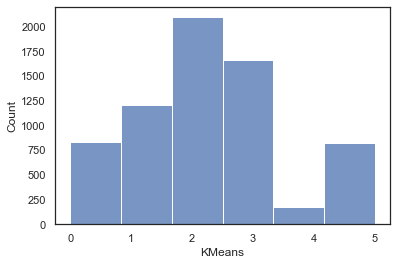

In [51]:
# How are the clusters distributed?
ax = sns.histplot(data=rs, x=c_nm, bins=k_pref);

In [ ]:
# Going to be a bit hard to read if 
# we plot every variable against every
# other variables, so we'll just pick a few
sns.set(style="white")
sns.pairplot(rs, 
             vars=cols_to_plot, 
             hue=c_nm, markers=".", height=3, diag_kind='kde');

And here's a map!

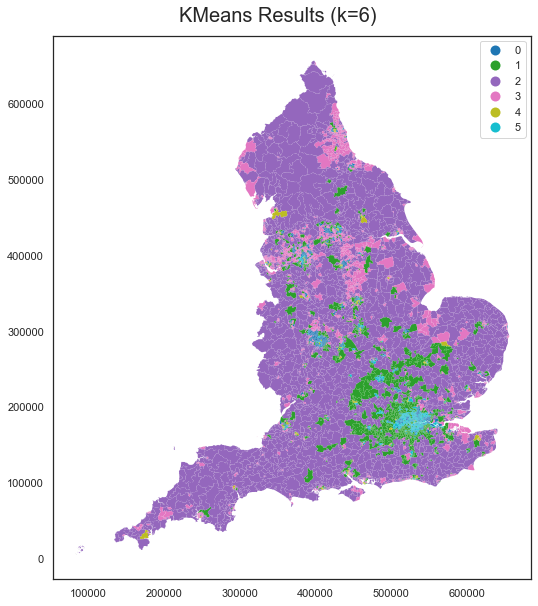

In [53]:
fig, ax = plt.subplots(figsize=(16,10))
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);

#### The 'Right' Number of Clusters

There's more than one way to find the 'right' number of clusters. In Singleton's _Geocomputation_ chapter they use WCSS to pick the 'optimal' number of clusters. The idea is that you plot the average WCSS for each number of possible clusters in the range of interest (2...n) and then look for a 'knee' (i.e. kink) in the curve. The principle of this approach is that you look for the point where there is declining benefit from adding more clusters. The problem is that there is always some benefit to adding more clusters (the perfect clustering is k==n), so you don't always see a knee.

Another way to try to make the process of selecting the number of clusters a little less arbitrary is called the silhouette plot and (like WCSS) it allows us to evaluate the 'quality' of the clustering outcome by examining the distance between each observation and the rest of the cluster. In this case it's based on Partitioning Around the Medoid (PAM).

Either way, to evaluate this in a systematic way, we want to do multiple k-means clusterings for multiple values of k and then we can look at which gives the best results...

Let's try clustering across a wider range.

.......................................
Largest silhouette score was 0.3161 for k=2


AttributeError: 'Figure' object has no attribute 'subtitle'

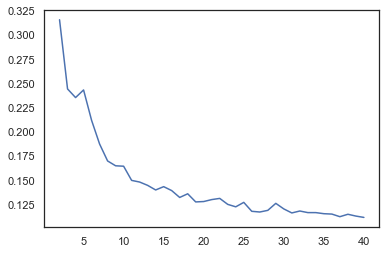

In [54]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score

x = []
y = []

for k in range(2,41):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(gdf_vars)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(gdf_vars, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.gcf().subtitle("Average Silhouette Scores");

In [ ]:
#Notes 05/04/2021 YH

#next step is to find out what the output will look like so we can provide this to the web team
#want to also discuss whether we should remove IMD and include underlying deprivation indicators instead to give greater flexibility to the clusters

In [ ]:
#Notes 15/04/2021 YH

#this 
#Looks like 5 clusters is optimal not 6